# Generating a Decomposition Viewer

Can we see the directional decomposition of a luma channel across different scales?

In [1]:
from collections import deque
import cv2
import time
import tkinter as tk
import numpy as np
from PIL import Image, ImageTk

from src.visualisers.camera_gui import BasicCameraGUI, DeComGUI

from src.var_processor.surface_stage import decompose

import cv2

In [2]:
camGUI = BasicCameraGUI()

camGUI.run()

We can use - Spacetime Modelling of Sound + Tkinter GU - CONT2 (CV2 PYRDOWN) for scale decomposition routine.

See here for colormap options - https://stackoverflow.com/questions/59478962/how-to-convert-a-grayscale-image-to-heatmap-image-with-python-opencv

In [3]:
decomGUI = DeComGUI()

decomGUI.run()

TypeError: 'NoneType' object is not subscriptable

Now let's do a version with PBT.

In [11]:
from src.var_processor.pb_threshold import pb_threshold, pb_residual_threshold

class PBTDeComGUI(DeComGUI):
    
    def update(self):
        # Get frame
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages + 4 - 1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Set A as input for next stage
            image = images[0]
            # PBT A - remember to cast to 8-bit
            A_pbt = pb_threshold(images[0].astype(np.uint8))*255
            # PBT differences
            diffs = list()
            for i in images[1:]:
                thresholded = pb_residual_threshold(i)
                rescaled = (thresholded*127)+127
                color_mapped = cv2.applyColorMap(rescaled.astype(np.uint8), cv2.COLORMAP_JET)
                diffs.append(color_mapped)
            images = [A_pbt.astype(np.uint8)] + diffs
            image_lists.append(images)

        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)

        self.window.after(10, self.update)

In [12]:
pbt_decomGUI = PBTDeComGUI()

pbt_decomGUI.run()

TypeError: 'NoneType' object is not subscriptable

In [4]:
pbt_decomGUI.cam.release()

Interesting that the differences are always hard to see. To see them we need to log and normalise.

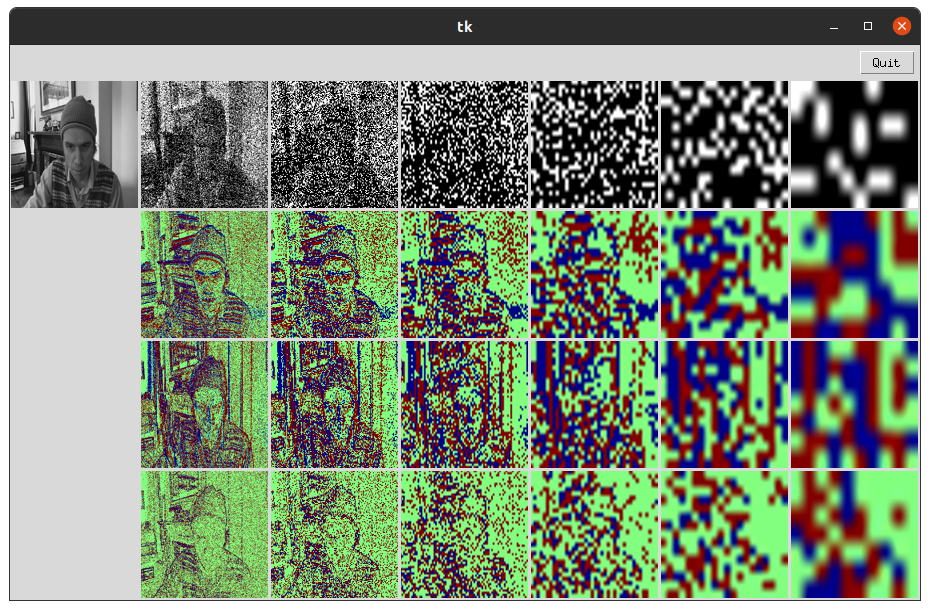

This is one where I accidentally binarise because of overflow!

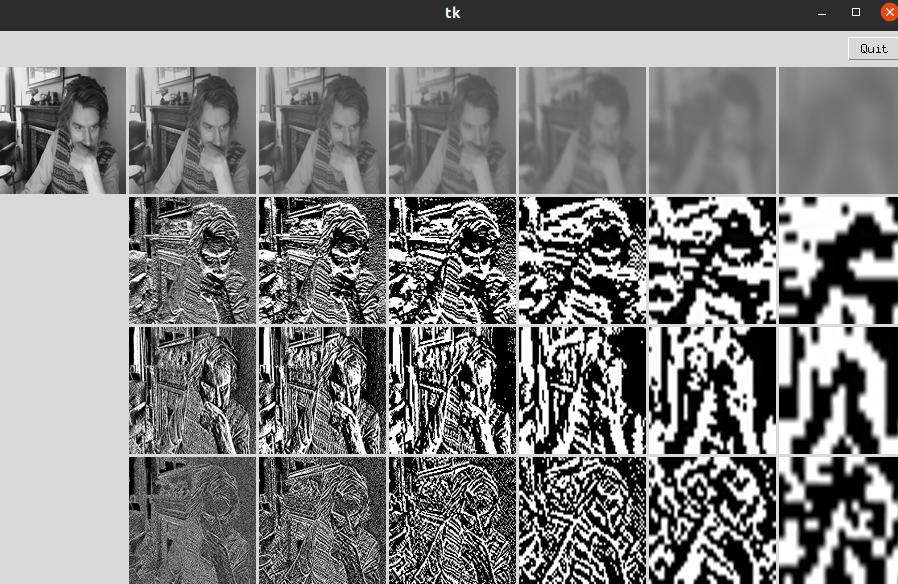

I remember - what is cool is that decompositions are light invariant - if I turn the light on and off the average changes but not the decompositions.

Also it reminds me that the lower resolution images have background noise - but this comes from the higher resolutions. If you were looking at the differences between different layers this would cancel out.

It also shows that binary is a good approximation - decompositions here are black and white anyway (this might be a scaling bug!). Yes - it was because we were using uint not int. But (signed) ints aren't displayed.

Binary also avoids the average smearing - we resharpen via binary thresholding.

In [7]:
class DeComDiffGUI(DeComGUI):
     
    def update(self):
        # Get frame
        _, frame = self.cam.read()
        Y = frame[:, :, 0]
        image = Y
        image_lists = [[Y]]
        # Iteratively decompose
        for _ in range(self.num_of_stages+4-1):
            # Convert to 16-bit to avoid overflow
            images = decompose(image.astype(np.int16))
            # Scale and convert back to 8-bit
            images[0] = images[0]//4
            images = [i.astype(np.int8) for i in images[1:]]
            image_lists.append(images)
            # Set the next image as the average of the set
            image = images[0]
        
        for frame, image_list in zip(self.frames, image_lists):
            frame.update(image_list)
            
        self.window.after(10, self.update)
    
    

In [8]:
decomGUI = DeComDiffGUI()

decomGUI.run()

TypeError: 'NoneType' object is not subscriptable

In [9]:
self = decomGUI
_, frame = self.cam.read()
Y = frame[:, :, 0]
image = Y
images = decompose(image.astype(np.int16))

In [10]:
images[1]

Exception ignored in: <function PhotoImage.__del__ at 0x7f27b1216e60>
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/ml_platform_3_7/lib/python3.7/site-packages/PIL/ImageTk.py", line 118, in __del__
    name = self.__photo.name
AttributeError: 'PhotoImage' object has no attribute '_PhotoImage__photo'


array([[  0,   0,   0, ...,   3,  -1,   0],
       [  0,   0,   1, ...,  -2,  -2,   0],
       [ -1,   1,   1, ...,   0,   4,   1],
       ...,
       [  3,   1,   2, ...,   2,   0,   0],
       [  2,   1,  -2, ...,   1,  19,  -1],
       [ -4,   3,   0, ...,  -8, -12, -21]], dtype=int16)

In [11]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


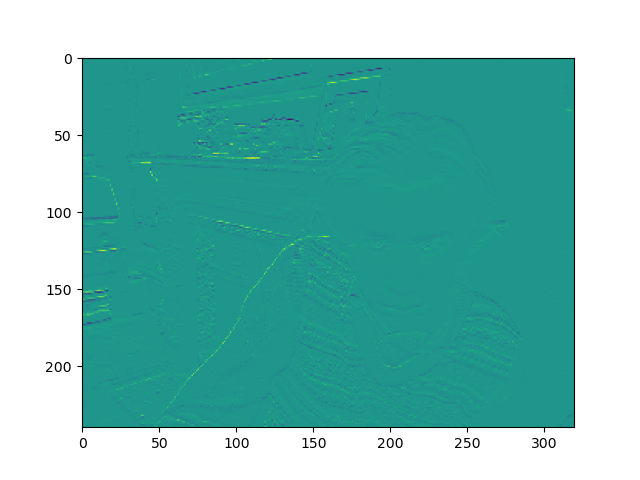

In [12]:
%matplotlib notebook
plt.imshow(images[1])

<IPython.core.display.Javascript object>


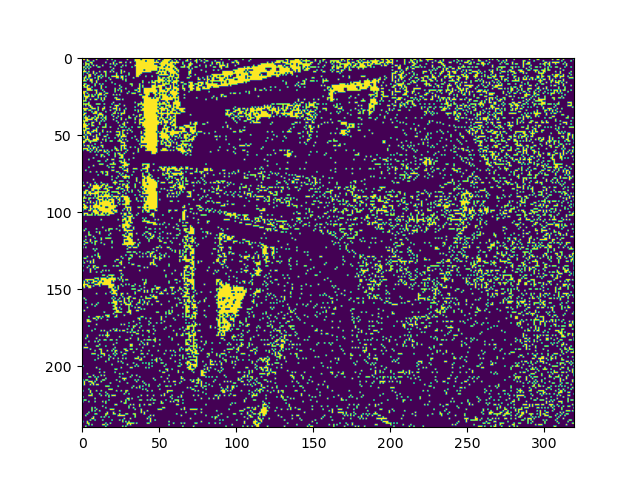

In [13]:
plt.imshow(images[1]==0)

Ah I'd forgotten about this. We need to PBT above and below based on difference distribution, dealing separately with both sides of the curve.

In [14]:
images[1].ravel().shape

(76800,)

<IPython.core.display.Javascript object>


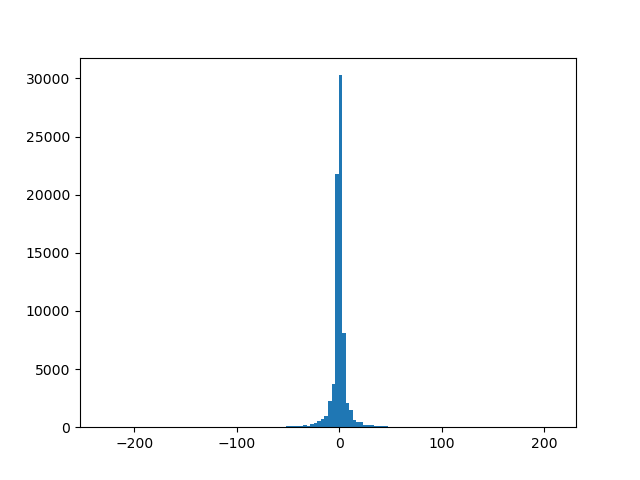

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 6.0000e+00,
        3.0000e+00, 5.0000e+00, 2.0000e+00, 5.0000e+00, 2.0000e+00,
        5.0000e+00, 1.0000e+00, 9.0000e+00, 2.0000e+00, 3.0000e+00,
        6.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00, 7.0000e+00,
        2.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00, 1.4000e+01,
        5.0000e+00, 1.4000e+01, 1.0000e+01, 1.7000e+01, 1.5000e+01,
        1.3000e+01, 1.8000e+01, 1.2000e+01, 1.6000e+01, 1.1000e+01,
        2.9000e+01, 1.6000e+01, 2.2000e+01, 2.7000e+01, 3.3000e+01,
        5.0000e+01, 5.1000e+01, 7.4000e+01, 6.4000e+01, 7.5000e+01,
        8.2000e+01, 7.6000e+01, 1.6100e+02, 1.4200e+02, 2.6700e+02,
        3.2300e+02, 5.7400e+02, 7.3100e+02, 9.6200e+02, 2.2740e+03,
        3.7060e+03, 2.1808e+04, 3.0280e+04, 8.1010e+03, 2.1230e+03,
        1.5160e+03, 6.5300e+02, 4.4900e+02, 4.23

In [15]:
plt.hist(images[1].ravel(), density=False, bins=128)

# TODO

I need to refine and refactor the visualisation to do the following:
* Use a single tested library function for sound and vision.
* Show signed integer and ternary images (start from the existing RGB/A functions but watch that 0 is dark/black).
* Show differences and scales for decompositions.
* Show reconstructed image.
* Optional: radio/buttons/checkboxes to turn on and off different levels/components.
* Optional: turn on/off different reconstructions.


## Don't re-invent the wheel

* Could have separation of data and visualisation as before.
    ** E.g. stage processing levels and sensor objects for data.
* Use expandible lists of images at each stage (possibly returned from method call on data object).
* SignalFrame at the moment plots a 1D signal but shares code with a 2D signal plot. We can create an abstract version.

So we have a method to create a basic GUI and a method to add a set of panels based on an image array.

The abstract GUI has an empty list of panels and canvas_content.

In the other method I was adding a ImagePanels object for each stage in the Init, then in the update calling the update method on each ImagePanels object and passing the image list.

On the sensor side, we have a Sensor object that returns a multi-dimensional array of original sensor data. We can use YSource to get a 2D array of luma data.

We have a stage that receives an input 2D image, decomposes and outputs the four surfaces. Include the downsampling as part of the stage or separate?

Each stage generates a set of 2D arrays as an output to an update method (e.g. surfaces = stage.iterate(input) - like forward()). The visualiser converts to a viewable image. We also get an output for the next stage input = stage.next_input(). 

What about the differences? We need a lower level set of arrays (lower_surfaces = stage\[i-1\].get_surfaces()) that we upsample (upsampled_surfaces = upsample(lower_surfaces)), differences = stage\[i\].residuals(upsampled_surfaces).

We can also have PBT.

Actually, the above "stage" is actually more similar to the StageWrapper class.
* Has a reconstruct method and an iterate method.
* Stack has a residuals property.

We also have the TransformMixin which as a simialr pre/post processing. Vec_len is the decomposition length.

Also we have crop to nearest power of two method. And polar mapping.

We can have a general preprocessing and postprocessing method that outputs a list of image lists - we can then choose to plot one or more of the lists via a list of flags - \[True, False, False\]. Example preprocessing:
* polar mapping
* log frequency
Post processing:
* PBT


<IPython.core.display.Javascript object>


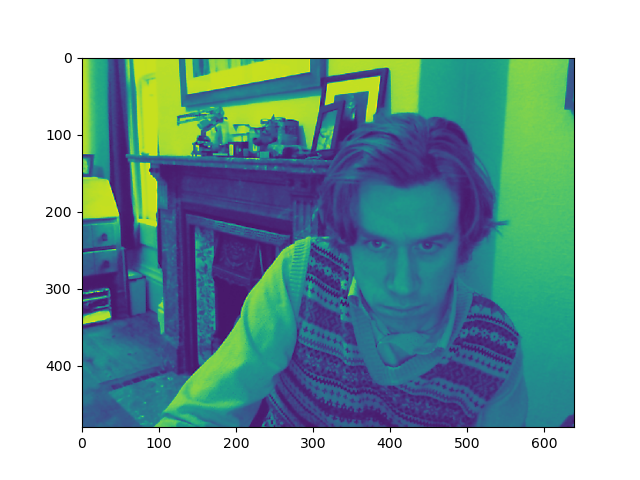

In [16]:
plt.imshow(Y)

In [31]:
# This is our function for 2D images
def decompose(image):
    """Decompose an image using the Hadamard transform."""
    H = image[:-1,:] - image[1:,:]
    V = image[:,:-1] - image[:,1:]
    # Work out top TLHC + BRHC
    d_1 = image[:-1,:-1] + image[1:,1:]
    # Then work out BLHC + TLHC
    d_2 = image[1:,:-1] + image[:-1,1:]
    D = d_1 - d_2
    # Average is sum of four shifted versions
    A = image[:-1,:-1] + image[1:,:-1] + image[:1,-1] + image[1:,1:]
    # Subsample and scale average
    surfaces = [A[::2, ::2]//4, H[::2, ::2], V[::2, ::2], D[::2, ::2]]
    return surfaces

In [32]:
[A, H, V, D] = decompose(Y.astype(np.int16))

See surface stack.py file.

So for 

In [33]:
print(A.shape, H.shape, V.shape, D.shape)

(240, 320) (240, 320) (240, 320) (240, 320)


Ah so our quick decompose has stride 1 not stride 2 in each dimension. So we don't have to explicitly downsample A if we have stride 2, 2, but we do if it has stride 1.

Also sub-sampling removes the shape differences problem!

Reverse Hadamard:
* P0 = A + H + V + D
* P1 = A - H + V - D
* P2 = A + H - V - D
* P3 = A - H - V + D

<IPython.core.display.Javascript object>


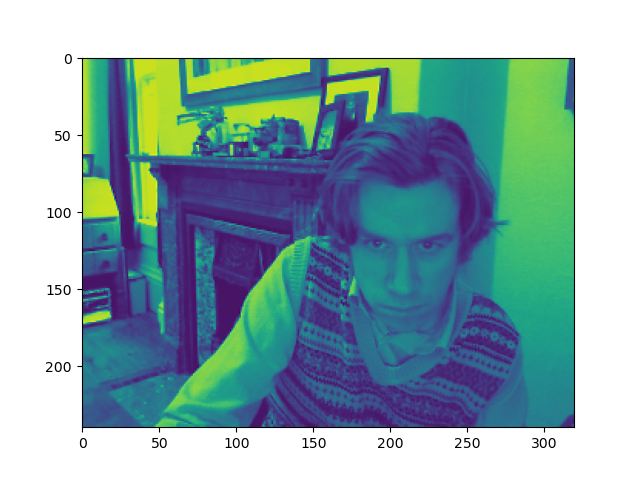

In [41]:
plt.imshow(A)

In [45]:
plt.imshow(H)

<IPython.core.display.Javascript object>


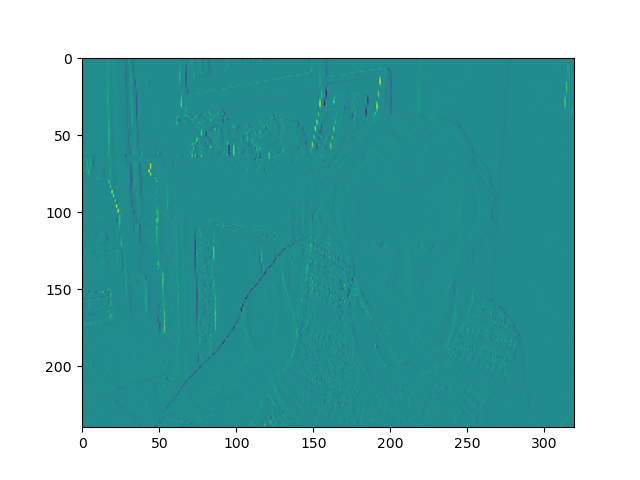

In [46]:
plt.imshow(V)

<IPython.core.display.Javascript object>


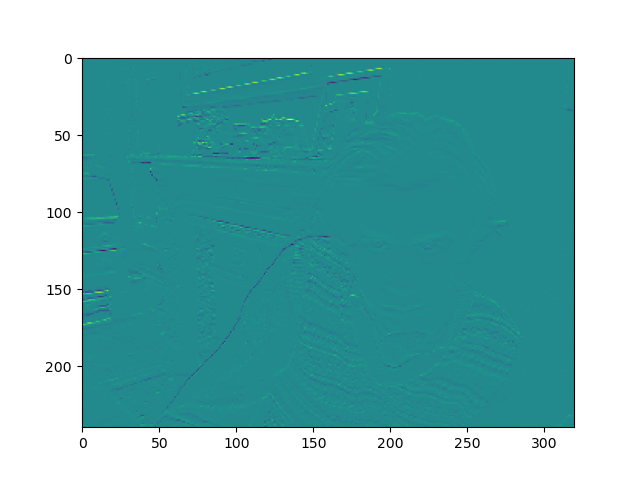

In [44]:
plt.imshow(D)

In [38]:
def recompose(surfaces):
    # Data = surfaces set
    [A, H, V, D] = surfaces
    # Create new blank image at x2 size
    blank_shape = (A.shape[0]*2, A.shape[1]*2)
    blank = np.zeros(blank_shape, dtype=np.int16)
    # Then recombine surfaces into a single image
    blank[::2, ::2] = A + H + V + D
    blank[::2, 1::2] = A + H - V - D
    blank[1::2, ::2] = A - H + V - D
    blank[1::2, 1::2] = A - H - V + D
    # Then convert back to 8-bit
    return blank.astype(np.uint8)

In [51]:
surfaces = [A, H//4, V//4, D//4]
image = recompose(surfaces)

<IPython.core.display.Javascript object>


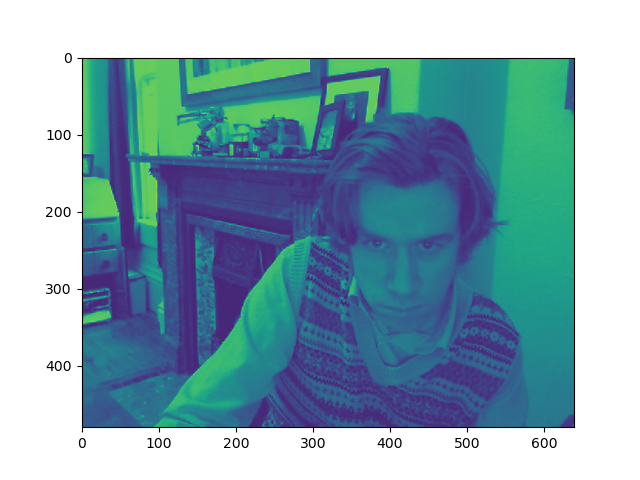

In [52]:
plt.imshow(image)

What has gone wrong here?

Added in the wrong way?

Or the effect of subsampling and dividing by 4?

The H and V need to average neighbouring differences? First of all we need to swap the order in the decompose...

It's overflow - values of 254 next to 2. We do need to divide by 4 if we are recasting to uint8.

<IPython.core.display.Javascript object>


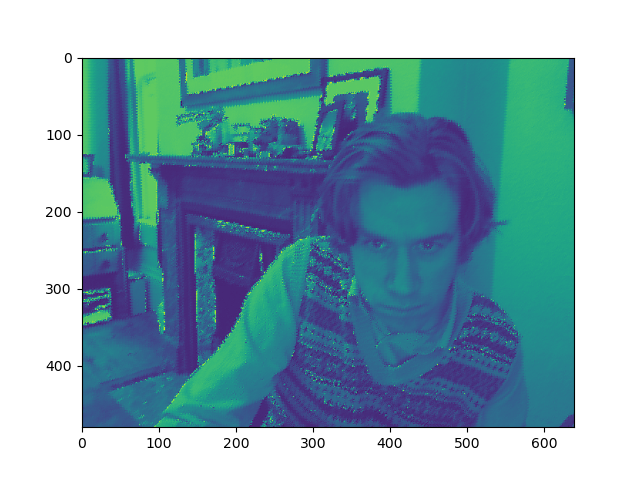

In [26]:
plt.imshow(image[300:324,0:24])

In [35]:
surfaces = decompose(blank)

In [48]:
image = recompose(surfaces)
plt.imshow(image)

ValueError: operands could not be broadcast together with shapes (479,639) (479,640) 

In [36]:
Y_shape = (surfaces[0][::2, ::2].shape[0]*2, surfaces[0][::2, ::2].shape[1]*2)
Y_dash = np.zeros(blank_shape, dtype=np.int16)
Y_dash[::2, ::2] = surfaces[0][::2, ::2]
Y_dash[1::2, ::2] = surfaces[1][::2, ::2]
Y_dash[::2, 1::2] = surfaces[2][::2, ::2]
Y_dash[1::2, 1::2] = surfaces[3][::2, ::2]

In [39]:
plt.imshow(Y_dash)

In [62]:
def decompose(image: np.ndarray, scale=True) -> list:
    """Decompose an image using the Hadamard transform."""
    # If unsigned 8-bit convert to signed 16-bit to allow computations
    if image.dtype == np.uint8:
        image = image.astype(np.int16)
    # Horizontal difference - TL - BL + TR - BR
    H = image[:-1, :-1] - image[1:, :-1] + image[:-1, 1:] - image[1:, 1:]
    # Vertical difference - TL - TR + BL - BR
    V = image[:-1, :-1] - image[:-1, 1:] + image[:-1, 1:] - image[1:, 1:]
    # Diagonal difference
    # Work out top (TL + BR) - (TR + BL)
    D = (image[:-1, :-1] + image[1:, 1:]) - (image[1:, :-1] + image[:-1, 1:])
    # Average is sum of four shifted versions - TL + BL + TR + BR
    A = image[:-1, :-1] + image[1:, :-1] + image[:1, -1] + image[1:, 1:]
    # Subsample and scale based on variable
    if scale:
        surfaces = [A[::2, ::2] // 4, H[::2, ::2] // 4, V[::2, ::2] // 4, D[::2, ::2]// 4]
    else:
        surfaces = [A[::2, ::2], H[::2, ::2], V[::2, ::2], D[::2, ::2]]
    return surfaces

In [63]:
test_array = np.array([[4, 4], [0, 0]], dtype=np.uint8)
surfaces = decompose(test_array)
print(test_array, '\n', surfaces)

[[4 4]
 [0 0]] 
 [array([[2]], dtype=int16), array([[2]], dtype=int16), array([[1]], dtype=int16), array([[0]], dtype=int16)]


In [64]:
test_array = np.array([[4, 0], [4, 0]], dtype=np.uint8)
surfaces = decompose(test_array)
print(test_array, '\n', surfaces)

[[4 0]
 [4 0]] 
 [array([[2]], dtype=int16), array([[0]], dtype=int16), array([[1]], dtype=int16), array([[0]], dtype=int16)]


<IPython.core.display.Javascript object>


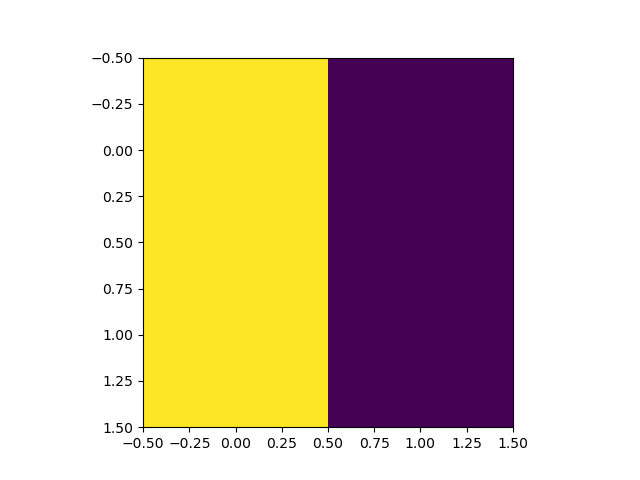

In [65]:
plt.imshow(test_array)

In [66]:
test_array = np.array([[4, 0], [0, 4]], dtype=np.uint8)
surfaces = decompose(test_array)
print(test_array, '\n', surfaces)

[[4 0]
 [0 4]] 
 [array([[2]], dtype=int16), array([[0]], dtype=int16), array([[0]], dtype=int16), array([[2]], dtype=int16)]


In [61]:
test = np.array([[1,2], [3,4]])
print(test)
print(test[:-1, :-1], test[1:, :-1], test[:1, -1], test[1:, 1:])

[[1 2]
 [3 4]]
[[1]] [[3]] [2] [[4]]
